# Análise Preditiva com SARIMAX

Neste notebook, apresentamos um modelo integrado de análise preditiva utilizando o SARIMAX (Seasonal Autoregressive Integrated Moving Average with Exogenous Variables). De forma interativa, o usuário pode selecionar a Unidade de Economia Nacional (UEN) e o horizonte de previsão, permitindo a geração de previsões visuais para os valores líquidos futuros com base em dados históricos e variáveis econômicas relevantes.

## Importação de Bibliotecas

Esta célula importa as bibliotecas necessárias para análise de dados (pandas e numpy), modelagem preditiva (SARIMAX do statsmodels), visualização (matplotlib) e criação de widgets interativos (ipywidgets). Também é utilizado um filtro para ignorar avisos que possam aparecer durante a execução do código.

In [9]:
! pip install pandas numpy scikit-learn statsmodels matplotlib ipywidgets

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from ipywidgets import widgets, interactive
from IPython.display import display, clear_output

import warnings
warnings.filterwarnings("ignore")

## Carrega os Dados

Aqui, os dados são carregados a partir de um arquivo Excel e armazenados em um DataFrame chamado df. Essa etapa é fundamental para iniciar a análise e modelagem dos dados.

In [5]:
# Carregar os dados
df = pd.read_excel('data/tabela_data_sarimax.xlsx')

## Prepara os Dados

Nesta célula, os dados são preparados para análise. O código converte a coluna Taxa_Ac._TRI_%_PIB para o tipo float, substituindo vírgulas por pontos. Além disso, valores ausentes nas colunas de valor líquido e índices de preços (IPCA) são preenchidos com a média das respectivas colunas para garantir que o modelo não tenha valores nulos.

In [6]:
# Preparação dos dados
df['Taxa_Ac._TRI_%_PIB'] = df['Taxa_Ac._TRI_%_PIB'].str.replace(',', '.').astype(float)
df['Vl_Liquido_Final'] = df['Vl_Liquido_Final'].fillna(df['Vl_Liquido_Final'].mean())
df['IPCA_ES'] = df['IPCA_ES'].fillna(df['IPCA_ES'].mean())
df['IPCA_BR'] = df['IPCA_BR'].fillna(df['IPCA_BR'].mean())
df['Taxa_Ac._TRI_%_PIB'] = df['Taxa_Ac._TRI_%_PIB'].fillna(df['Taxa_Ac._TRI_%_PIB'].mean())

## Função para Executar o Modelo

Esta célula define uma função chamada executar_modelo, que filtra os dados com base na Unidade de Economia Nacional (UEN) selecionada e realiza a modelagem usando o algoritmo SARIMAX. A função também gera previsões para os próximos meses, com gráficos que mostram os dados reais e as previsões.

In [7]:
# Filtra os dados de acordo com a UEN selecionada
def executar_modelo(uen_selecionada, n_months):
    uen_mapping = {0: 'Digital', 1: 'Televisão', 2: 'Rádio', 3: 'Geral'}  # Adiciona a opção "Geral"

    # Se "Geral" for selecionado, usa todos os dados
    if uen_selecionada == 3:
        df_filtrado = df.copy()  # Copia todos os dados
    else:
        df_filtrado = df[df['UEN'] == uen_selecionada]  # Filtra conforme a UEN

    # Carregar e preparar os dados
    df_filtrado['data'] = pd.to_datetime(df_filtrado['data'])
    df_filtrado.set_index('data', inplace=True)
    df_filtrado = df_filtrado.resample('ME').agg({
        'IPCA_ES': 'mean',
        'IPCA_BR': 'mean',
        'Vl_Liquido_Final': 'sum',
        'Taxa_Ac._TRI_%_PIB': 'mean',
    }).reset_index()

    df_filtrado.set_index('data', inplace=True)
    df_filtrado = df_filtrado.asfreq('ME')

    X = df_filtrado[['IPCA_ES', 'IPCA_BR', 'Taxa_Ac._TRI_%_PIB']]
    y = df_filtrado['Vl_Liquido_Final']

    # Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    # Ajustar o modelo SARIMAX
    model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)

    # Fazer previsões futuras
    last_date = df_filtrado.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_months, freq='ME')
    future_X = pd.DataFrame(index=future_dates)
    for col in X.columns:
        future_X[col] = X[col].mean()

    future_predictions = model_fit.predict(start=len(y_train), end=len(y_train) + n_months - 1, exog=future_X)

    # Criar uma tabela com as previsões futuras
    tabela_previsoes = pd.DataFrame({
    'Data': future_dates,  # Usa as datas futuras diretamente
    'Previsão': future_predictions
    }).reset_index(drop=True)  # Reseta o índice para evitar que ele apareça



    # Exibir a tabela
    print("\n Tabela de Previsões Futuras:")
    print(tabela_previsoes)
    print("\n Gráficos:")

    # Plotar apenas as previsões futuras
    plt.figure(figsize=(12, 6))
    plt.plot(future_dates, future_predictions, label='Previsões Futuras', color='orange', linestyle='--')
    plt.title(f'Previsões Futuras para os Próximos {n_months} Meses - {uen_mapping[uen_selecionada]}', fontsize=16)
    plt.xlabel('Data', fontsize=14)
    plt.ylabel('Valor Líquido', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plotar os dados reais e as previsões futuras juntos
    plt.figure(figsize=(12, 6))
    plt.plot(df_filtrado.index, df_filtrado['Vl_Liquido_Final'], label='Dados Reais', color='blue')
    plt.plot(future_dates, future_predictions, label='Previsões Futuras', color='orange', linestyle='--')
    plt.title(f'Dados Reais e Previsões Futuras - {uen_mapping[uen_selecionada]}', fontsize=16)
    plt.xlabel('Data', fontsize=14)
    plt.ylabel('Valor Líquido', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


## Widgets para Interatividade
Nesta seção, widgets interativos são criados para permitir que o usuário selecione a UEN e o número de meses para previsão. Um botão é adicionado para executar o modelo quando clicado. A função on_button_clicked gerencia a interação do usuário, limpando a saída anterior e exibindo novamente os widgets antes de chamar a função de execução do modelo.

RadioButtons(description='Selecione:', layout=Layout(width='80%'), options=(('Geral', 3), ('Digital', 0), ('Te…

IntSlider(value=24, continuous_update=False, description='Meses de Previsão:', max=24, min=1, style=SliderStyl…

Button(button_style='success', description='Executar Modelo', layout=Layout(width='50%'), style=ButtonStyle())


 Tabela de Previsões Futuras:
         Data      Previsão
0  2024-07-31  1.043805e+07
1  2024-08-31  9.447235e+06
2  2024-09-30  9.436095e+06
3  2024-10-31  1.122122e+07
4  2024-11-30  1.516238e+07
5  2024-12-31  9.207835e+06
6  2025-01-31  7.681059e+06
7  2025-02-28  9.024962e+06
8  2025-03-31  9.463246e+06
9  2025-04-30  1.003579e+07
10 2025-05-31  1.086300e+07
11 2025-06-30  1.055759e+07
12 2025-07-31  1.167019e+07
13 2025-08-31  1.070488e+07
14 2025-09-30  1.063380e+07
15 2025-10-31  1.243872e+07
16 2025-11-30  1.636511e+07
17 2025-12-31  1.047173e+07
18 2026-01-31  8.989311e+06
19 2026-02-28  1.029501e+07
20 2026-03-31  1.074364e+07
21 2026-04-30  1.125416e+07
22 2026-05-31  1.221267e+07
23 2026-06-30  1.186520e+07

 Gráficos:


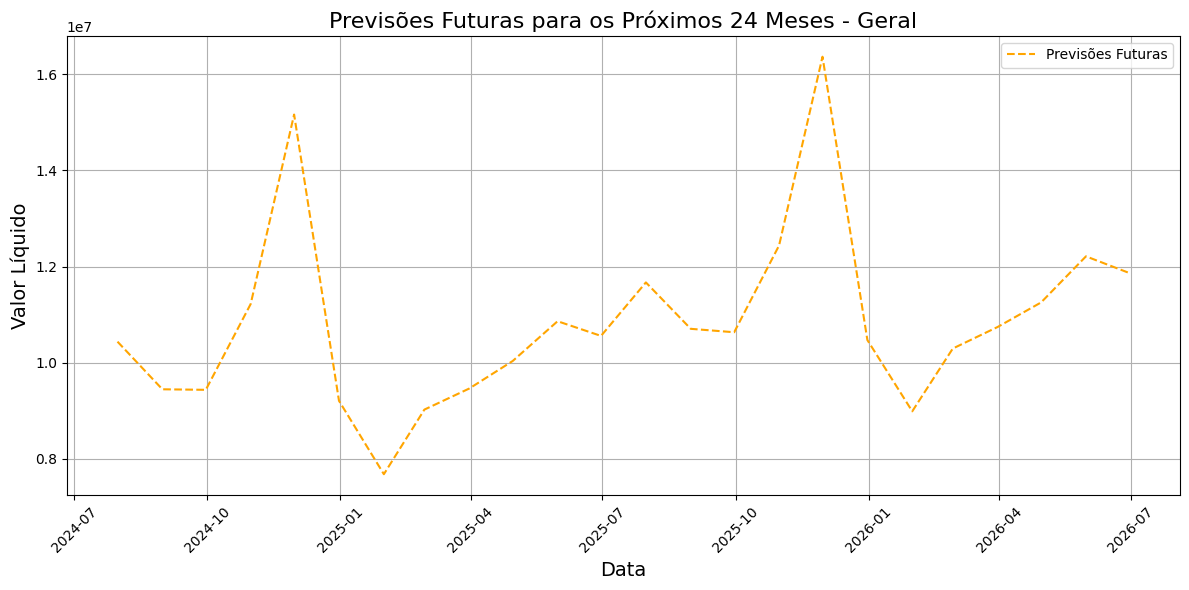

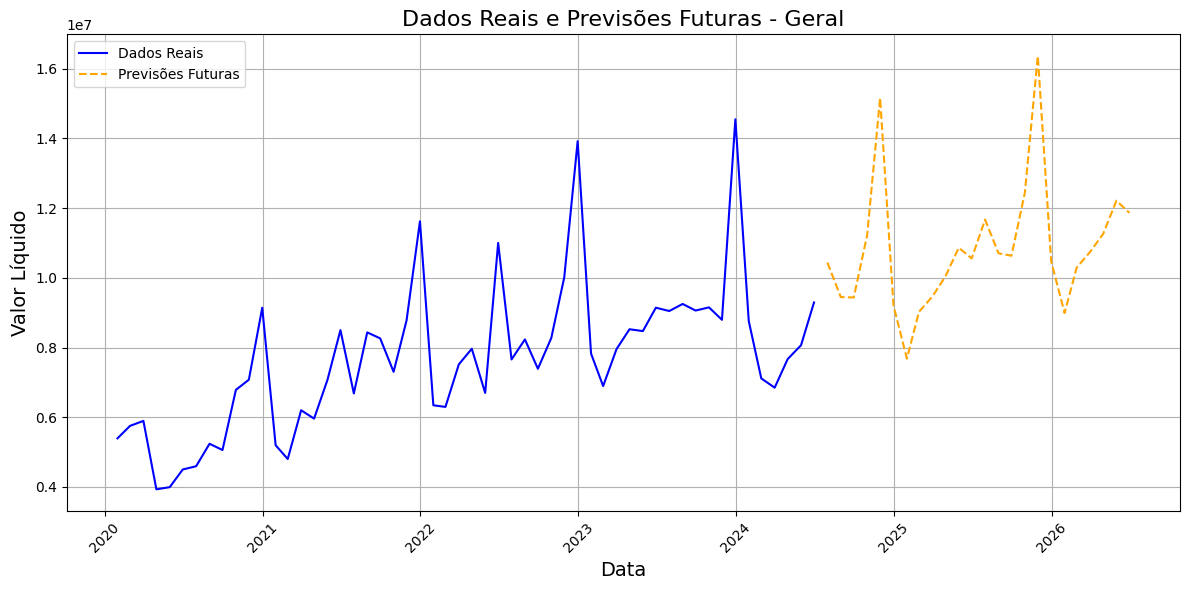

In [8]:
# Widgets para interatividade
uen_widget = widgets.RadioButtons(
    options=[('Geral', 3), ('Digital', 0), ('Televisão', 1), ('Rádio', 2)],
    description='Selecione:',
    value=3,  # A opção 'Geral' é selecionada por padrão
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='80%'),  # Ajusta a largura do widget
)

n_months_widget = widgets.IntSlider(
    value=12,
    min=1,
    max=24,
    step=1,
    description='Meses de Previsão:',
    continuous_update=False,  # Desabilita atualizações contínuas
    style={'description_width': 'initial'},  # Ajusta a largura da descrição
)

botao_executar = widgets.Button(
    description='Executar Modelo',
    button_style='success',  # Estilo do botão
    layout=widgets.Layout(width='50%'),  # Ajusta o layout do botão
)

# Função para lidar com o clique do botão
def on_button_clicked(b):
    clear_output(wait=True)
    display(uen_widget, n_months_widget, botao_executar)  # Re-exibe os widgets
    executar_modelo(uen_widget.value, n_months_widget.value)

botao_executar.on_click(on_button_clicked)

# Exibir widgets em uma coluna
widgets.VBox([uen_widget, n_months_widget, botao_executar])


## Conclusão

Neste notebook, demonstramos a aplicação do modelo SARIMAX para a previsão de valores líquidos futuros com base em dados históricos e variáveis econômicas. A abordagem interativa permitiu uma análise flexível, onde os usuários puderam explorar diferentes Unidades de Economia Nacional (UEN) e ajustar o horizonte de previsão. Os resultados obtidos, apresentados em gráficos, ilustram a importância das variáveis exógenas na modelagem de dados temporais. Essa análise pode servir como uma ferramenta valiosa para a tomada de decisões estratégicas, contribuindo para uma melhor compreensão das tendências de receita e seus determinantes.